In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4642,17-11-2023,28.7045
4643,20-11-2023,28.7109
4644,21-11-2023,28.7568
4645,22-11-2023,28.7992


In [4]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [5]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


In [6]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [7]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


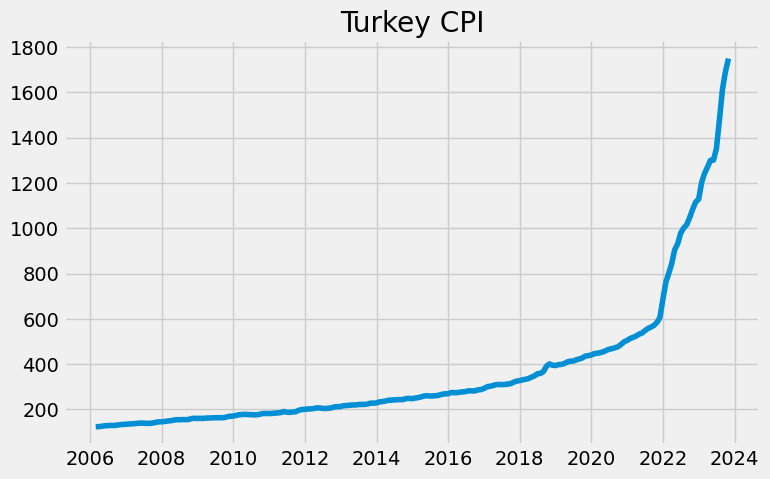

In [8]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [9]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [10]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
money

,Para Arzi
2006-02-28,2.423895
2006-03-31,2.494857
2006-04-30,2.521919
2006-05-31,2.751947
2006-06-30,2.791388
...,...
2023-07-31,114.784753
2023-08-31,120.253200
2023-09-30,123.493114
2023-10-31,127.637320


In [11]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933329


In [12]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",end="2023-10-29",freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-05-31,9.5
2023-06-30,9.5
2023-07-31,9.3
2023-08-31,9.2


In [13]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4634,07-11-2023,83.43
4635,08-11-2023,81.46
4636,09-11-2023,81.74
4637,10-11-2023,83.66


In [14]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle


brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381


In [15]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-28','2023-12-29' , freq='1M')

df14["Brent"]=brent["TP_BRENTPETROL_EUBP"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])

df14

,Brent
TIME,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381


In [16]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10
212,2023-10,1.047935e+10


In [17]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870
212,2023-10,104.793503


In [18]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-02-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503


In [19]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.5
1,2006-3,17.5
2,2006-4,17.5
3,2006-5,17.5
4,2006-6,17.5
...,...,...
209,2023-7,17.5
210,2023-8,23.5
211,2023-9,31.0
212,2023-10,33.0


In [20]:
dates=pd.date_range('2006-02-28','2023-12-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.5
2006-03-31,17.5
2006-04-30,17.5
2006-05-31,17.5
2006-06-30,17.5
...,...
2023-07-31,17.5
2023-08-31,23.5
2023-09-30,31.0


In [21]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.3500
2023-10-31,59.3925


In [22]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100) (2).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-10-01",freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-05-31,181.176925,179.718446,179.734862
2023-06-30,180.070938,186.170934,179.520633
2023-07-31,191.652101,194.140963,184.782561
2023-08-31,184.907520,183.148681,176.126980


In [23]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-12-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-07-31,29.480000
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.900000


In [24]:
sanayi=pd.read_excel("C:/Users/Bora/Downloads/sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-05-31,146.666835
2023-06-30,148.351267
2023-07-31,147.798299
2023-08-31,146.674452


In [25]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-12-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.7600
2006-03-31,15.3300
2006-04-30,15.1750
2006-05-31,14.9250
2006-06-30,15.5840
...,...
2023-07-31,33.1250
2023-08-31,29.4125
2023-09-30,41.6560
2023-10-31,43.8925


In [26]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-12-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-07-31,7.70
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57


In [27]:
borc=evds.get_data(["TP.KB.A09"],startdate="28-02-2010",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2010-02-28",end="2023-11-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2010-02-28,3.394344e+08
2010-03-31,3.406784e+08
2010-04-30,3.431629e+08
2010-05-31,3.405206e+08
2010-06-30,3.431419e+08
...,...
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09


In [28]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-06-30,87.02
2023-07-31,81.68
2023-08-31,85.52
2023-09-30,89.55


In [29]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-06-30,51.56
2023-07-31,48.68
2023-08-31,52.39
2023-09-30,55.46


In [30]:
data=pd.DataFrame()
data["USDTL"]=df6["USD/TL"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Borç"]=borc["Borç"].shift(1)
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)
data

,USDTL,ParaArzi,Motorin,Perakende Satış,Sanayi,Borç,Kredi,M3,REDK,REDKT,TÜFE
Tarih,,,,,,,,,,,
2011-04-30,-0.810542,1.738088,-1.218711,-0.176965,-0.162949,0.684613,2.978727,1.642254,1.593625,2.284537,0.866270
2011-05-31,-0.399628,0.113812,-1.660706,1.110822,1.016932,0.570506,3.568114,0.477281,-3.090570,-1.121135,2.420827
2011-06-30,0.415548,2.361933,2.055258,2.490629,1.895703,0.194110,3.122424,2.450559,-1.878794,-3.463549,-1.430743
2011-07-31,2.804715,2.187652,2.237631,1.258223,1.925345,0.019793,2.898935,2.189939,-3.289474,-3.817214,-0.409400
2011-08-31,3.747733,0.569285,1.664460,-0.296514,2.983648,0.318355,3.279260,0.444077,-4.213626,-5.533295,0.726069
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,15.146856,33.393665,2.931099,-0.372743,9.689321,5.675617,15.439600,-6.136520,-5.585725,9.488824
2023-08-31,10.505114,5.943431,26.763908,-4.684198,-0.760392,2.618269,1.850455,5.968276,4.701273,7.621200,9.086793
2023-09-30,5.071342,4.764088,4.843457,-0.712124,-0.125062,4.384930,2.080815,4.845313,4.712348,5.859897,4.753114


In [31]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
data=data.dropna(axis=0)
data=data[['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','Şok','M3','İşsizlik','Politika Faizi',"TÜFE"]]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.5140,11.01,3.604096,0.82,3.375162,-0.584687,3.267877,9.0220,-3.691204,-5.094658,1,3.413428,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.4575,0.00,-0.850238,0.73,1.804994,0.808574,1.451593,10.6275,2.179150,0.919060,0,2.079333,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,15.8900,0.00,0.128936,0.80,0.451349,0.193691,0.341852,11.3125,0.471546,0.641623,1,0.229599,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.8625,0.00,-0.863760,0.73,0.796760,0.478162,0.129671,11.0200,4.682667,5.892031,1,0.730196,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.4280,0.00,-1.367417,0.80,-0.362357,0.091080,0.468727,10.4940,1.283880,2.058652,0,-0.093468,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,1.507585,-7.526882,3.200118,32.0225,0.00,1.434427,7.37,4.931112,2.663712,3.535416,31.4625,1.004595,-1.762413,0,4.796282,9.5,9.09,0.043076
2023-06-30,7.066073,16.807611,-0.119192,38.5600,0.00,1.148476,7.55,-1.017069,2.406884,5.711697,39.5920,-7.925087,-11.057444,0,-1.142443,9.5,12.84,3.920498
2023-07-31,11.475241,33.393665,2.931099,45.8250,34.00,-0.372743,7.70,15.146856,9.689321,5.675617,33.1250,-6.136520,-5.585725,1,15.439600,9.3,17.50,9.488824


In [32]:
'''from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
features=data.columns
train=data.iloc[:-12,:]
test=data.iloc[-12:,:]
best_mse=float("inf")
best_features=[]
for combo in combinations(features, 10):
        selected_features = list(combo)
        if 'TÜFE' not in selected_features:
            selected_features.append("TÜFE")
            
        train_subset = train[selected_features]
        test_subset = test[selected_features]
        
        model=VAR(train_subset)
        for i in range(len(pg)):
           results=model.fit(maxlags=pg.iloc[i]["maxlags"],ic=pg.iloc[i]["ic"],trend=pg.iloc[i]["trend"],verbose=pg.iloc[i]["verbose"])
           y_pred = results.forecast(train_subset[-i:].values,steps=test_subset.shape[0])
           rmse1 = np.sqrt(mean_squared_error(test["TÜFE"], y_pred[:,-1]))

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
           if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features
            best_params=[pg.iloc[i]["maxlags"],pg.iloc[i]["ic"],pg.iloc[i]["trend"],pg.iloc[i]["verbose"]]

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi parametreler:{}".format(best_params))
print("En iyi RMSE değeri:", best_mse)'''

'from sklearn.cross_decomposition import PLSRegression\nfrom sklearn.svm import SVR\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\nfeatures=data.columns\ntrain=data.iloc[:-12,:]\ntest=data.iloc[-12:,:]\nbest_mse=float("inf")\nbest_features=[]\nfor combo in combinations(features, 10):\n        selected_features = list(combo)\n        if \'TÜFE\' not in selected_features:\n            selected_features.append("TÜFE")\n            \n        train_subset = train[selected_features]\n        test_subset = test[selected_features]\n        \n        model=VAR(train_subset)\n        for i in range(len(pg)):\n           results=model.fit(maxlags=pg.iloc[i]["maxlags"],ic=pg.iloc[i]["ic"],trend=pg.iloc[i]["trend"],verbose=pg.iloc[i]["verbose"])\n           y_pred = results.forecast(train_subset[-i:].values,steps=test_subset.shape[0])\n           rmse1 = np.sqrt(mean_squared_error(test["TÜFE"], y_pred[:,-1]))\n\n        \n        # En iyi MSE değe

In [33]:
'''from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
features=['Kredi Faizi', 'Enflasyon Belirsizliği', 'REDK', 'REDKT', 'M3', 'TÜFE']
train=data[features].iloc[:-12,:]
test=data[features].iloc[-12:,:]
best_mse=float("inf")
best_features=[]
model=VAR(train)
for i in range(len(pg)):
           results=model.fit(maxlags=pg.iloc[i]["maxlags"],ic=pg.iloc[i]["ic"],trend=pg.iloc[i]["trend"],verbose=pg.iloc[i]["verbose"])
           y_pred = results.forecast(train[pg.iloc[i]["maxlags"]:].values,steps=test.shape[0])
           rmse1 = np.sqrt(mean_squared_error(test["TÜFE"], y_pred[:,-1]))

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
           if rmse1 < best_mse:
            best_mse = rmse1
            best_params=[pg.iloc[i]["maxlags"],pg.iloc[i]["ic"],pg.iloc[i]["trend"],pg.iloc[i]["verbose"]]

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi parametreler:{}".format(best_params))
print("En iyi RMSE değeri:", best_mse)'''

'from sklearn.cross_decomposition import PLSRegression\nfrom sklearn.svm import SVR\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\nfeatures=[\'Kredi Faizi\', \'Enflasyon Belirsizliği\', \'REDK\', \'REDKT\', \'M3\', \'TÜFE\']\ntrain=data[features].iloc[:-12,:]\ntest=data[features].iloc[-12:,:]\nbest_mse=float("inf")\nbest_features=[]\nmodel=VAR(train)\nfor i in range(len(pg)):\n           results=model.fit(maxlags=pg.iloc[i]["maxlags"],ic=pg.iloc[i]["ic"],trend=pg.iloc[i]["trend"],verbose=pg.iloc[i]["verbose"])\n           y_pred = results.forecast(train[pg.iloc[i]["maxlags"]:].values,steps=test.shape[0])\n           rmse1 = np.sqrt(mean_squared_error(test["TÜFE"], y_pred[:,-1]))\n\n        \n        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin\n           if rmse1 < best_mse:\n            best_mse = rmse1\n            best_params=[pg.iloc[i]["maxlags"],pg.iloc[i]["ic"],pg.iloc[i]["trend"],pg.iloc[i]["verbose"]]\n\n# En 

In [34]:
'''from itertools import combinations
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import numpy as np

# Tahmin edilecek son üç gözlem
true_values = np.array([3.43])
features=data.columns
# En iyi özellikleri ve en iyi RMSE'yi saklamak için değişkenler
best_features = []
best_rmse = float("inf")
best_predictions = None

# Her bir özellik kombinasyonu için tahmin yap ve en iyi özellikleri bul

for combo in combinations(features, 10):
        selected_features = list(combo)
        if 'TÜFE' not in selected_features:
            selected_features.append("TÜFE")

        model = VAR(data[features])
        results = model.fit(maxlags=3, ic='aic', trend='ctt', verbose=True)
        y_pred = results.forecast(data[features].values, steps=1)[:,-1]

        rmse = np.sqrt(mean_squared_error(true_values, y_pred))

        if rmse < best_rmse:
            best_rmse = rmse
            best_features = selected_features
            best_predictions = y_pred

print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi RMSE değeri:", best_rmse)
print("En yakın tahminler:")
print(best_predictions)'''


'from itertools import combinations\nfrom statsmodels.tsa.api import VAR\nfrom sklearn.metrics import mean_squared_error\nimport numpy as np\n\n# Tahmin edilecek son üç gözlem\ntrue_values = np.array([3.43])\nfeatures=data.columns\n# En iyi özellikleri ve en iyi RMSE\'yi saklamak için değişkenler\nbest_features = []\nbest_rmse = float("inf")\nbest_predictions = None\n\n# Her bir özellik kombinasyonu için tahmin yap ve en iyi özellikleri bul\n\nfor combo in combinations(features, 10):\n        selected_features = list(combo)\n        if \'TÜFE\' not in selected_features:\n            selected_features.append("TÜFE")\n\n        model = VAR(data[features])\n        results = model.fit(maxlags=3, ic=\'aic\', trend=\'ctt\', verbose=True)\n        y_pred = results.forecast(data[features].values, steps=1)[:,-1]\n\n        rmse = np.sqrt(mean_squared_error(true_values, y_pred))\n\n        if rmse < best_rmse:\n            best_rmse = rmse\n            best_features = selected_features\n       

In [35]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=data.iloc[:,:-1].columns
X = data[features]
X = sm.add_constant(X)
y=data[["TÜFE"]]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
model = sm.OLS(y, X).fit()
rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [36]:

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white




# White testini uygulayın
het_white_results = het_white(model.resid, X)
print("LM Statistic:", het_white_results[0])
print("LM-Test p-value:", het_white_results[1])
print("F-Statistic:", het_white_results[2])
print("F-Test p-value:", het_white_results[3])

# P-value değerine göre hipotezi değerlendirin
alpha = 0.05
if het_white_results[1] < alpha:
    print("Null hipotezi reddedilir. Hata terimlerinin varyansları homojen değildir.")
else:
    print("Null hipotezi kabul edilir. Hata terimlerinin varyansları homojen.")


LM Statistic: 117.0
LM-Test p-value: 0.45651358985394885
F-Statistic: nan
F-Test p-value: nan
Null hipotezi kabul edilir. Hata terimlerinin varyansları homojen.


In [37]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [38]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [39]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDKT', 'Şok', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [40]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [41]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [42]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-12,:]
X_test=X.iloc[-12:,:]
y_train=y.iloc[:-12,:]
y_test=y.iloc[-12:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [43]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Kernel Regression,0.796718
Gaussian Regression,0.799523
Lars Regression,0.803475
Bayesian Regression,0.813113
SGD Regressor,0.847205
Linear Regression,0.917095
Lasso Regression,0.939163


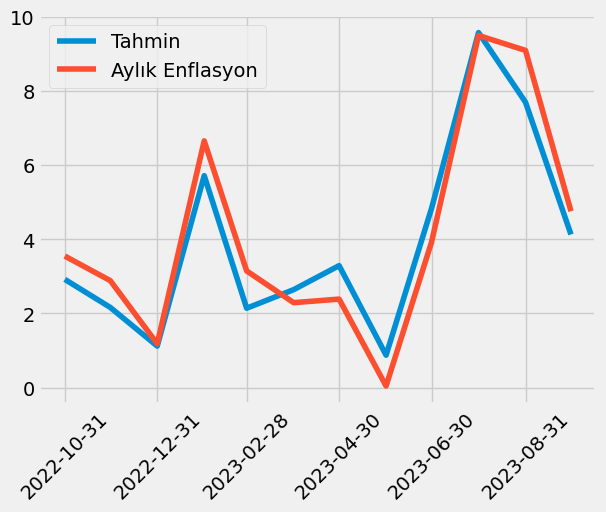

In [44]:
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
plt.plot(tahminler["Kernel Regression"],label="Tahmin")
plt.plot(tahminler["Aylık Enflasyon"],label="Aylık Enflasyon")
plt.xticks(pd.date_range(start="2022-10",periods=len(tahminler),freq="1M")[::2],rotation=45)
plt.legend()
plt.show()

In [45]:
from statsmodels.tsa.arima.model import ARIMA

model=auto_arima(df6["USD/TL"].iloc[:-1],seasonal=True,m=9,information_criterion="bic")
model_fit = model.fit(df6["USD/TL"].iloc[:-1])
usdtahmin = model_fit.predict(26)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USDTL"]
row=pd.DataFrame({"USDTL":df6.iloc[208:-1,0]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.728117
2023-12-31,29.406137
2024-01-31,30.084157
2024-02-29,30.762177
2024-03-31,31.440198


In [46]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import month_plot
import warnings


model=auto_arima(df14["Brent"],seasonal=True,m=6)
model_fit = model.fit(df14["Brent"])




forecast = model_fit.predict(26)
brenttahmin=pd.DataFrame(forecast)
brenttahmin.columns=["Brent"]
row=pd.DataFrame({"Brent":df14.iloc[209:214,0]},index=pd.date_range(start="2023-07-30",end="2023-12-29",freq="1M"))
brenttahmin=pd.concat([row,brenttahmin],axis=0)
brenttahmin

,Brent
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381
2023-10-31,90.595909
2023-11-30,85.020000
2023-12-31,83.844885
2024-01-31,81.181574
2024-02-29,80.080654
2024-03-31,78.450555
2024-04-30,78.618020


In [47]:
model=auto_arima(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"],seasonal=False,information_criterion="aic")
model_fit = model.fit(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"])
perakendetahmin = model_fit.predict(28)
perakendetahmin=pd.DataFrame(perakendetahmin)
perakendetahmin.columns=["Perakende"]
row=pd.DataFrame({"Perakende":perakende1.iloc[163:,2]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
perakendetahmin=pd.concat([row,perakendetahmin],axis=0)
perakendetahmin

,Perakende
2023-08-31,176.126980
2023-09-30,174.872738
2023-10-31,176.854745
2023-11-30,178.631767
2023-12-31,179.300273
2024-01-31,179.968130
2024-02-29,180.635987
2024-03-31,181.303844
2024-04-30,181.971701
2024-05-31,182.639558


In [48]:
model=auto_arima(money["Para Arzi"].iloc[:-1],seasonal=True,m=10)
model_fit = model.fit(money["Para Arzi"].iloc[:-1])



# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.predict(26)
paraarzitahmin=pd.DataFrame(forecast)
paraarzitahmin.columns=["Para Arzi"]
paraarzitahmin=pd.concat([pd.DataFrame({"Para Arzi":money.iloc[209:-1,0]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M")),paraarzitahmin],axis=0)
paraarzitahmin

,Para Arzi
2023-07-31,114.784753
2023-08-31,120.253200
2023-09-30,123.493114
2023-10-31,127.637320
2023-11-30,133.074670
2023-12-31,137.457248
2024-01-31,143.304942
2024-02-29,148.998207
2024-03-31,154.418702
2024-04-30,159.278808


In [49]:
model=auto_arima(kfaiz["Kredi Faizi"].iloc[:-1],seasonal=True,m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"].iloc[:-1])

forecast = model_fit.predict(26)
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:-1,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.350000
2023-10-31,59.392500
2023-11-30,60.822798
2023-12-31,61.271307
2024-01-31,61.966965
2024-02-29,62.514882
2024-03-31,63.479735
2024-04-30,64.499956
2024-05-31,64.511641


In [50]:
model=SARIMAX(mfaiz["Mevduat Faizi"],order=(3,1,1))
model_fit = model.fit()
forecast =model_fit.predict(start=mfaiz.index[-4],end="2025-12-31")


mfaiztahmin=pd.DataFrame(forecast)
mfaiztahmin.columns=["Mevduat Faizi"]
mfaiztahmin

,Mevduat Faizi
2023-08-31,28.425383
2023-09-30,34.798940
2023-10-31,42.038096
2023-11-30,41.210008
2023-12-31,51.438900
2024-01-31,50.748162
2024-02-29,50.248227
2024-03-31,52.680595
2024-04-30,52.035712
2024-05-31,51.564801


In [51]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=df6.iloc[:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=df6.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [52]:
exog=pd.DataFrame()
exog["X"]=df6["USD/TL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2006-03-31,82.598113
2006-04-30,93.884368
2006-05-31,96.222566
2006-06-30,103.560400
2006-07-31,116.361278
...,...
2023-07-31,1985.734693
2023-08-31,2303.136460
2023-09-30,2529.968892
2023-10-31,2483.938761


In [53]:
testexog=usdtahmin.rolling(2).mean().dropna().iloc[5:,0]*brenttahmin.iloc[4:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [54]:


model=auto_arima(motorin["Motorin"].iloc[38:],X=exog)
model_fit = model.fit(motorin["Motorin"].iloc[38:],X=exog)



forecast = model.predict(25,X=testexog)
motorintahmin=pd.DataFrame(forecast)
motorintahmin.columns=["Motorin"]
new_row=pd.DataFrame({"Motorin":motorin.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",end="2023-12-29",freq="1M"))
motorintahmin=pd.concat([new_row,motorintahmin],axis=0)
motorintahmin

,Motorin
2023-10-31,38.900000
2023-11-30,38.980000
2023-12-31,39.160462
2024-01-31,38.510713
2024-02-29,38.508862
2024-03-31,38.283037
2024-04-30,38.854043
2024-05-31,39.972758
2024-06-30,41.007170
2024-07-31,40.941279


In [55]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-01-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,35
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [56]:
model=auto_arima(df3["Kredi"].iloc[:-1],m=5,seasonal=True)
model_fit = model.fit(df3["Kredi"].iloc[:-1])
forecast = model_fit.predict(26)
kreditahmin=pd.DataFrame(forecast)
kreditahmin.columns=["Kredi"]
new_row=pd.DataFrame({"Kredi":df3["Kredi"].iloc[209:-1]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
kreditahmin=pd.concat([new_row,kreditahmin],axis=0)
kreditahmin

,Kredi
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,106.825693
2023-12-31,110.981474
2024-01-31,114.319151
2024-02-29,116.266267
2024-03-31,118.575376
2024-04-30,120.804478


In [57]:
model=auto_arima(borc["Borç"],seasonal=True,m=2)

# Modeli eğitin
model_fit = model.fit(borc["Borç"])

# Gelecekteki değerleri tahmin edin
n_forecast = 27# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.predict(27)
borctahmin=pd.DataFrame(forecast)
borctahmin.columns=["Borç"]
new_row=pd.DataFrame({"Borç":borc.iloc[161:,0]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
borctahmin=pd.concat([new_row,borctahmin],axis=0)
borctahmin

,Borç
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.077164e+09
2023-12-31,3.183073e+09
2024-01-31,3.291774e+09
2024-02-29,3.398739e+09
2024-03-31,3.506784e+09
2024-04-30,3.614157e+09


In [58]:
model=auto_arima(redk["REDK"],seasonal=False)
model_fit = model.fit(redk["REDK"])
forecast = model_fit.predict(27)
redktahmin=pd.DataFrame(forecast)
redktahmin.columns=["REDK"]
new_row=pd.DataFrame({"REDK":[85.52,89.55,89.03]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
redktahmin=pd.concat([new_row,redktahmin],axis=0)
redktahmin

,REDK
2023-08-31,85.520000
2023-09-30,89.550000
2023-10-31,89.030000
2023-11-30,88.469313
2023-12-31,88.447105
2024-01-31,88.431530
2024-02-29,88.420607
2024-03-31,88.412947
2024-04-30,88.407575
2024-05-31,88.403808


In [59]:
model=auto_arima(redkt["REDKT"],seasonal=False)
model_fit = model.fit(redkt["REDKT"])
forecast = model_fit.predict(27)
redkttahmin=pd.DataFrame(forecast)
redkttahmin.columns=["REDKT"]
new_row=pd.DataFrame({"REDKT":[52.39,55.46,55.90]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
redkttahmin=pd.concat([new_row,redkttahmin],axis=0)
redkttahmin

,REDKT
2023-08-31,52.390000
2023-09-30,55.460000
2023-10-31,55.900000
2023-11-30,55.033280
2023-12-31,54.013923
2024-01-31,53.144884
2024-02-29,52.390178
2024-03-31,51.722432
2024-04-30,51.120827
2024-05-31,50.569528


In [60]:
model=auto_arima(m3["M3 Para Arzi"].iloc[:-1],seasonal=True,m=9)
model_fit = model.fit(m3["M3 Para Arzi"].iloc[:-1])
forecast = model_fit.predict(26)
m3tahmin=pd.DataFrame(forecast)
m3tahmin.columns=["M3 Para Arzi"]
new_row=pd.DataFrame({"M3 Para Arzi":m3["M3 Para Arzi"].iloc[209:-1]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
m3tahmin=pd.concat([new_row,m3tahmin],axis=0)
m3tahmin

,M3 Para Arzi
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933329
2023-11-30,135.252142
2023-12-31,139.838778
2024-01-31,145.083136
2024-02-29,151.567369
2024-03-31,155.616521
2024-04-30,160.290342


In [61]:
model=auto_arima(pfaiz["Politika Faizi"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(26)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2023-12-29",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin

,Politika Faizi
2023-08-31,23.500000
2023-09-30,31.000000
2023-10-31,33.000000
2023-11-30,35.000000
2023-12-31,36.701464
2024-01-31,38.021623
2024-02-29,39.045928
2024-03-31,39.840683
2024-04-30,40.457329
2024-05-31,40.935783


In [62]:
faiztahmin.columns=["Faiz"]


In [63]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [64]:
exog=pfaiz["Politika Faizi"].iloc[95:-2]
exog=np.array(exog).reshape(-1,1)

In [65]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [66]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(28,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2023-10-31,9.086846
2023-11-30,9.104906
2023-12-31,9.130381
2024-01-31,9.161728
2024-02-29,9.203738
2024-03-31,9.247604
2024-04-30,9.291963
2024-05-31,9.338090
2024-06-30,9.383399
2024-07-31,9.427472


In [67]:
model = auto_arima(enf_belirsizlik["Enflasyon Belirsizliği"],seasonal=True,m=5)

# Modeli eğitin
model_fit = model.fit(enf_belirsizlik["Enflasyon Belirsizliği"])

forecast = model_fit.predict(25)
enfbelirsizliktahmin=pd.DataFrame(forecast)
enfbelirsizliktahmin.columns=["Enflasyon Belirsizliği"]
new_row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik["Enflasyon Belirsizliği"].iloc[-4:]},index=pd.date_range(start="2023-08-30",end="2023-12-29",freq="1M"))
enfbelirsizliktahmin=pd.concat([new_row,enfbelirsizliktahmin],axis=0)
enfbelirsizliktahmin

,Enflasyon Belirsizliği
2023-08-31,6.810000
2023-09-30,7.300000
2023-10-31,5.570000
2023-11-30,4.490000
2023-12-31,4.192767
2024-01-31,3.420662
2024-02-29,3.834809
2024-03-31,3.665485
2024-04-30,3.410585
2024-05-31,2.951552


In [68]:
exog=pfaiz["Politika Faizi"].iloc[:-2]
exog=np.array(exog).reshape(-1,1)
testexog=faiztahmin.iloc[2:]
testexog=np.array(testexog).reshape(-1,1)

In [69]:
model = auto_arima(sanayi["Sanayi"].iloc[12:],X=exog,seasonal=False,information_criterion="aic")


model_fit = model.fit(sanayi["Sanayi"].iloc[12:],X=exog)

forecast = model_fit.predict(28,X=testexog)
sanayitahmin=pd.DataFrame(forecast)
sanayitahmin.columns=["Sanayi"]
new_row=pd.DataFrame({"Sanayi":sanayi.iloc[-2:,0]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
sanayitahmin=pd.concat([new_row,sanayitahmin],axis=0)
sanayitahmin

,Sanayi
2023-08-31,146.674452
2023-09-30,146.491018
2023-10-31,148.009664
2023-11-30,149.195849
2023-12-31,150.139466
2024-01-31,150.908115
2024-02-29,151.562455
2024-03-31,152.140792
2024-04-30,152.667661
2024-05-31,153.159036


In [70]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin["USDTL"].rolling(3).mean(),paraarzitahmin["Para Arzi"].shift(1),motorintahmin["Motorin"],enfbelirsizliktahmin,perakendetahmin,sanayitahmin,kreditahmin.rolling(2).mean(),redktahmin,redkttahmin,m3tahmin.shift(1),borctahmin.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["Politika Faizi"]=faiztahmin["Faiz"]



tahmindf["Şok"]=0

tahmindf=tahmindf[['USDTL', 'Motorin', 'Perakende', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDK','REDKT','Şok','M3 Para Arzi','İşsizlik','Politika Faizi']]

tahmindf.columns=data.columns[:-1]
tahmindf=tahmindf.dropna(axis=0)
tahmindf=tahmindf.iloc[:-10,:]
tahmindf.iloc[0,10]=45.17
tahmindf

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik,Politika Faizi
2023-11-30,2.112784,0.205656,1.004792,60.822798,0.0,0.801424,4.490000,3.355820,3.741984,2.045953,45.170000,-0.629773,-1.550482,0,3.373522,9.104906,35.000000
2023-12-31,2.892034,0.462961,0.374237,61.271307,0.0,0.632469,4.192767,4.260000,3.721284,2.924106,51.438900,-0.025103,-1.852257,0,3.298483,9.130381,36.701464
2024-01-31,2.602971,-1.659196,0.372480,61.966965,35.0,0.511956,3.420662,3.293322,3.441752,3.440409,50.748162,-0.017609,-1.608915,0,3.391174,9.161728,38.021623
2024-02-29,2.305710,-0.004807,0.371097,62.514882,0.0,0.433602,3.834809,4.254191,3.414984,2.345663,50.248227,-0.012352,-1.420092,0,3.750289,9.203738,39.045928
2024-03-31,2.253745,-0.586424,0.369725,63.479735,0.0,0.381583,3.665485,3.972832,3.249471,1.845834,52.680595,-0.008663,-1.274564,0,4.469322,9.247604,39.840683
2024-04-30,2.204071,1.491538,0.368363,64.499956,0.0,0.346304,3.410585,3.637960,3.178957,1.932456,52.035712,-0.006076,-1.163141,0,2.671520,9.291963,40.457329
2024-05-31,2.156539,2.879275,0.367011,64.511641,0.0,0.321859,2.951552,3.147356,3.061883,1.940104,51.564801,-0.004262,-1.078422,0,3.003422,9.338090,40.935783
2024-06-30,2.111014,2.587792,0.365669,65.948580,0.0,0.304559,2.607290,3.047823,2.982455,2.415967,52.630493,-0.002989,-1.014515,0,3.208728,9.383399,41.307013
2024-07-31,2.067372,-0.160681,0.364337,66.363531,0.0,0.292062,2.769738,3.168713,2.889116,2.774570,52.270992,-0.002096,-0.966774,0,3.091648,9.427472,41.595049
2024-08-31,2.025497,0.713839,0.363015,66.558682,0.0,0.282854,3.139259,2.658217,2.812198,2.345014,51.991181,-0.001470,-0.931560,0,3.161090,9.470671,41.818535


In [71]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'Şok', 'İşsizlik', 'Politika Faizi','REDK']
X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1749.04
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2023-11-30", end="2025-03-27", freq="1M"))
tüfetahmin1

,SGD Regressor
2023-11-30,1795.413261
2023-12-31,1851.002957
2024-01-31,1930.680880
2024-02-29,1986.326843
2024-03-31,2038.827555
2024-04-30,2098.126475
2024-05-31,2161.408235
2024-06-30,2228.194102
2024-07-31,2293.024568
2024-08-31,2360.630169


In [72]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi',  'Şok', 'Politika Faizi','REDK']


X= data[features]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1749.04
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2023-11-30", end="2025-03-27", freq="1M"))
tüfetahmin2


,Linear Regression
2023-11-30,1786.991134
2023-12-31,1833.592007
2024-01-31,1902.895756
2024-02-29,1947.940601
2024-03-31,1989.188201
2024-04-30,2036.602009
2024-05-31,2087.317648
2024-06-30,2140.860610
2024-07-31,2191.909305
2024-08-31,2245.094206


In [73]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'İşsizlik', 'Politika Faizi']

X = data[features]
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X,y)


tüfetahmin5 = []
result = 1749.04
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2023-11-30", end="2025-03-27", freq="1M"))
tüfetahmin5

,Lasso Regression
2023-11-30,1796.128026
2023-12-31,1852.550130
2024-01-31,1935.632421
2024-02-29,1992.821860
2024-03-31,2046.612379
2024-04-30,2108.494679
2024-05-31,2175.547682
2024-06-30,2247.595392
2024-07-31,2317.937157
2024-08-31,2390.711967


In [74]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Sanayi', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok', 'Politika Faizi','REDKT']


X = data[features]
y=data["TÜFE"]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)



tüfetahmin6 = []
result = 1749.04
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2023-11-30", end="2025-03-27", freq="1M"))
tüfetahmin6


,Lars Regression
2023-11-30,1792.171158
2023-12-31,1843.880282
2024-01-31,1918.737310
2024-02-29,1970.749037
2024-03-31,2018.789609
2024-04-30,2074.493146
2024-05-31,2134.828107
2024-06-30,2200.858564
2024-07-31,2266.582027
2024-08-31,2333.632397


In [104]:
features=data.iloc[:,:-1].columns
X = data[features]
y=data["TÜFE"]
krr = KernelRidge()
krr.fit(X, y)

tüfetahmin7 = []
result = 1749.04
krrtahmin=krr.predict(tahmindf[features])
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2023-11-30", end="2025-03-27", freq="1M"))
tüfetahmin7

,Kernel Regression
2023-11-30,1801.452211
2023-12-31,1864.892005
2024-01-31,1945.843851
2024-02-29,2010.256113
2024-03-31,2069.737728
2024-04-30,2140.244882
2024-05-31,2211.934795
2024-06-30,2287.732041
2024-07-31,2364.903172
2024-08-31,2441.059613


In [76]:
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
        'Şok', 'M3', 'İşsizlik', 'Politika Faizi']

X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1749.04  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-11-30,1798.484272
2023-12-31,1856.951842
2024-01-31,1930.047106
2024-02-29,1987.193414
2024-03-31,2038.427406
2024-04-30,2101.609921
2024-05-31,2162.180740
2024-06-30,2221.191622
2024-07-31,2278.197760
2024-08-31,2335.298760


In [77]:
features=['Motorin', 'Perakende Satış', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'Şok', 'İşsizlik', 'Politika Faizi','REDK']
X = data[features]
y=data["TÜFE"]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-11-30,1798.978282
2023-12-31,1858.269731
2024-01-31,1945.104157
2024-02-29,2005.422282
2024-03-31,2062.975711
2024-04-30,2128.245542
2024-05-31,2198.384926
2024-06-30,2272.333883
2024-07-31,2343.789470
2024-08-31,2418.741895


In [105]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
#tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
#tüfetahmin.iloc[1,:]=tüfetahmin.iloc[1,:]+9.7
tüfetahmin

,SGD Regressor,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,Ortalama
2023-11-30,1795.413261,1796.128026,1792.171158,1801.452211,1798.484272,1798.978282,1797.104535
2023-12-31,1851.002957,1852.550130,1843.880282,1864.892005,1856.951842,1858.269731,1854.591158
2024-01-31,1930.680880,1935.632421,1918.737310,1945.843851,1930.047106,1945.104157,1934.340954
2024-02-29,1986.326843,1992.821860,1970.749037,2010.256113,1987.193414,2005.422282,1992.128258
2024-03-31,2038.827555,2046.612379,2018.789609,2069.737728,2038.427406,2062.975711,2045.895065
2024-04-30,2098.126475,2108.494679,2074.493146,2140.244882,2101.609921,2128.245542,2108.535774
2024-05-31,2161.408235,2175.547682,2134.828107,2211.934795,2162.180740,2198.384926,2174.047414
2024-06-30,2228.194102,2247.595392,2200.858564,2287.732041,2221.191622,2272.333883,2242.984267
2024-07-31,2293.024568,2317.937157,2266.582027,2364.903172,2278.197760,2343.789470,2310.739026
2024-08-31,2360.630169,2390.711967,2333.632397,2441.059613,2335.298760,2418.741895,2380.012467


In [106]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]
'''
dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]'''





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [107]:
row=pd.DataFrame({"SGD Regressor":1749.04,"Lasso Regression":1749.04,"Lars Regression":1749.04,"Gaussian Regression":1749.04,"Kernel Regression":1749.04,"Bayessian Regression":1749.04,"Ortalama":1749.04},index=pd.date_range(start="2023-10-30",periods=1,freq="1M"))
tüfetahmin=pd.concat([row,tüfetahmin],axis=0)
tüfetahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Ortalama
2023-10-31,1749.040000,1749.040000,1749.040000,1749.040000,1749.040000,1749.040000,1749.040000
2023-11-30,1795.413261,1796.128026,1792.171158,1798.484272,1801.452211,1798.978282,1797.104535
2023-12-31,1851.002957,1852.550130,1843.880282,1856.951842,1864.892005,1858.269731,1854.591158
2024-01-31,1930.680880,1935.632421,1918.737310,1930.047106,1945.843851,1945.104157,1934.340954
2024-02-29,1986.326843,1992.821860,1970.749037,1987.193414,2010.256113,2005.422282,1992.128258
2024-03-31,2038.827555,2046.612379,2018.789609,2038.427406,2069.737728,2062.975711,2045.895065
2024-04-30,2098.126475,2108.494679,2074.493146,2101.609921,2140.244882,2128.245542,2108.535774
2024-05-31,2161.408235,2175.547682,2134.828107,2162.180740,2211.934795,2198.384926,2174.047414
2024-06-30,2228.194102,2247.595392,2200.858564,2221.191622,2287.732041,2272.333883,2242.984267
2024-07-31,2293.024568,2317.937157,2266.582027,2278.197760,2364.903172,2343.789470,2310.739026


In [108]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin.iloc[0,:]=aylıktahmin.iloc[0,:]+1.69
aylıktahmin.iloc[1,:]=aylıktahmin.iloc[1,:]+0.57
aylıktahmin.iloc[2,:]=aylıktahmin.iloc[2,:]+0.16
aylıktahmin.iloc[6,:]=aylıktahmin.iloc[6,:]+0.53
aylıktahmin["Ortalama"]=aylıktahmin.mean(axis=1)
aylıktahmin["Medyan"]=aylıktahmin.median(axis=1)
aylıktahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Ortalama,Medyan
2023-11-30,4.341355,4.382221,4.155990,4.516938,4.686627,4.545182,4.438052,4.438052
2023-12-31,3.666206,3.711319,3.455278,3.820936,4.091592,3.865840,3.768574,3.768574
2024-01-31,4.464581,4.644753,4.219755,4.096304,4.500833,4.832864,4.459888,4.464581
2024-02-29,2.882194,2.954561,2.710727,2.960876,3.310248,3.101023,2.986724,2.960876
2024-03-31,2.643105,2.699214,2.437681,2.578209,2.958907,2.869891,2.697996,2.697996
2024-04-30,2.908481,3.023645,2.759254,3.099572,3.406574,3.163868,3.060453,3.060453
2024-05-31,3.546108,3.710136,3.438419,3.412115,3.879613,3.825643,3.635573,3.635573
2024-06-30,3.089924,3.311704,3.093010,2.729230,3.426740,3.363786,3.169328,3.169328
2024-07-31,2.909552,3.129645,2.986265,2.566466,3.373259,3.144590,3.018646,3.018646
2024-08-31,2.948316,3.139637,2.958215,2.506411,3.220277,3.197916,2.995523,2.995523


In [109]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin10.columns=["CPI"]


tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(28))
tüfetahmin11
    

,CPI
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511
2023-04-30,43.684170
2023-05-31,39.585301
2023-06-30,38.213519
2023-07-31,47.831733
2023-08-31,58.943534


In [110]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(28))
tüfetahmin12

,CPI
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511
2023-04-30,43.684170
2023-05-31,39.585301
2023-06-30,38.213519
2023-07-31,47.831733
2023-08-31,58.943534


In [111]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(28))
tüfetahmin13

,CPI
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511
2023-04-30,43.684170
2023-05-31,39.585301
2023-06-30,38.213519
2023-07-31,47.831733
2023-08-31,58.943534


In [112]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(28))
tüfetahmin14

,CPI
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511
2023-04-30,43.684170
2023-05-31,39.585301
2023-06-30,38.213519
2023-07-31,47.831733
2023-08-31,58.943534


In [113]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(28))
tüfetahmin15

,CPI
2022-11-30,84.389260
2022-12-31,64.269597
2023-01-31,57.682481
2023-02-28,55.179828
2023-03-31,50.508511
2023-04-30,43.684170
2023-05-31,39.585301
2023-06-30,38.213519
2023-07-31,47.831733
2023-08-31,58.943534


In [114]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(28))

In [115]:
tüfe = 1749.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2023-11-30",end="2025-03-27",freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(28))

In [116]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)
ekim=pd.DataFrame({"TÜFE":3.43},index=pd.date_range(start="2023-10-30",periods=1,freq="1M"))
aylık=pd.concat([aylık,ekim],axis=0)
aylık.to_csv('aylık.csv')

In [117]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]])
aylık1=pd.DataFrame(aylık1)
aylık1=aylık1.set_index(pd.date_range(start="2014-01-31",end="2025-03-29",freq="1M"))
aylık1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

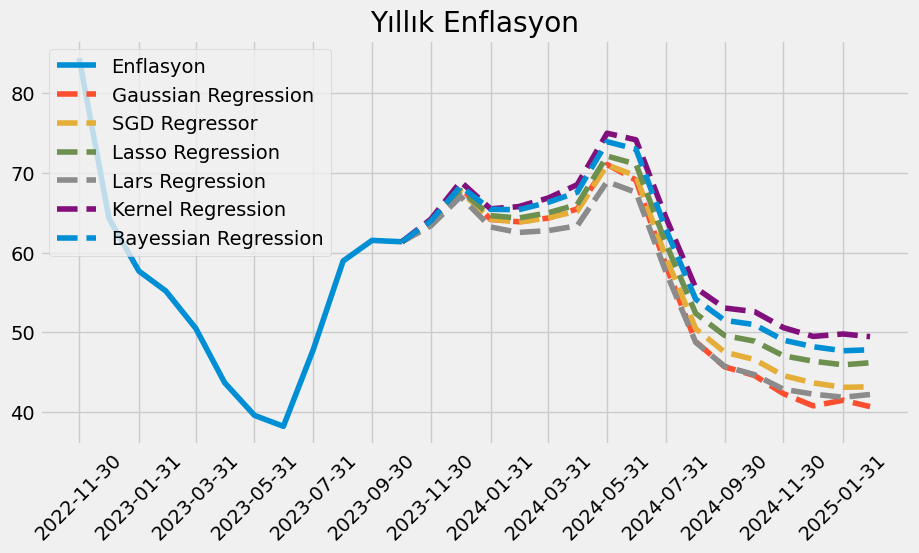

In [118]:
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[:12],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[11:],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[11:],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[11:],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[11:],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[11:],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[11:],'--',label="Bayessian Regression")
plt.legend(loc=0)
plt.xticks(rotation=45)
plt.xticks(pd.date_range(start="2022-11-30",end="2025-03-29",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [121]:
yıllıktahmin["Maksimum"]=yıllıktahmin["Kernel Regression"]
yıllıktahmin["Minimum"]=yıllıktahmin["Gaussian Regression"]
yıllıktahmin.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')
df.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/df.csv')

In [123]:
yıllıktahmin

,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Maksimum,Minimum
2022-11-30,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260,84.389260
2022-12-31,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597
2023-01-31,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481
2023-02-28,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828
2023-03-31,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511
2023-04-30,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170
2023-05-31,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301
2023-06-30,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519
2023-07-31,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733
2023-08-31,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534


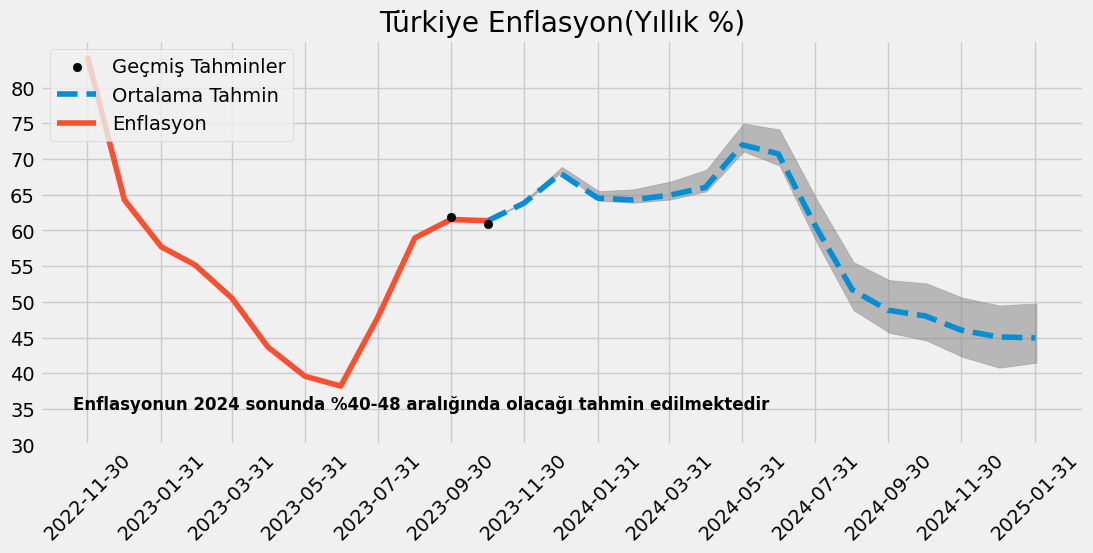

In [122]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(12,5))
plt.scatter(x=yıllıktahmin.index[10:12],y=[61.94,60.84],color='black',zorder=3,label='Geçmiş Tahminler')
plt.plot(yıllıktahmin["Ortalama"].iloc[11:27],'--',label="Ortalama Tahmin")
plt.plot(yıllıktahmin["Ortalama"].iloc[:12],label="Enflasyon")
plt.fill_between(yıllıktahmin.iloc[11:].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[11:].shift(1), yıllıktahmin["Minimum"].iloc[11:].shift(1), alpha=0.5, color='gray')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2024-06')

plt.text(annotation_date, 35, 'Enflasyonun 2024 sonunda %40-48 aralığında olacağı tahmin edilmektedir', fontsize=12, color='black', horizontalalignment='right',fontweight='bold')

plt.xticks(yıllıktahmin.index[::2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend(loc=2)
plt.show()
